# Bike Sharing Demand - Linear Regression

### Project goal

Bike sharing systems are a means of renting bicycles across a city, enabling people to rent a bike from a one location and return it to a different place on an as-needed basis.

The data generated by these systems makes them attractive for researchers. In this case, bike sharing systems function as a sensor network, which can be used to study mobility in a city and help companies to better understand their clients' needs and behaviour. 

The goal of this project is to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

### Table of Content

- Pre-Feature Engineering/ Data cleaning
  - create time-related features
  - missing values
  - outliers
- EDA
  - time
  - weather
  - membership
  - other features
- Train-Test Split
- Forward Feature Selection
- Feature Engineering
- Linear Regression
- Optimize Results
  - Recursive Feature Elimination
  - Polynomial Features
  - Ridge
  - Lasso
  - GridSearch for Hyperparameter Optimization
- Results

### Data fields

datetime - hourly date + timestamp

season

  - 1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather

- 1: Clear, Few clouds, Partly cloudy, Partly cloudy

- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

#### Import libraries

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, make_scorer

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso

from sklearn.model_selection import GridSearchCV

#### Load data

In [ ]:
pwd = os.getcwd()
df = pd.read_csv(pwd + '/data.csv', sep=",")

## Data overview

In [ ]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


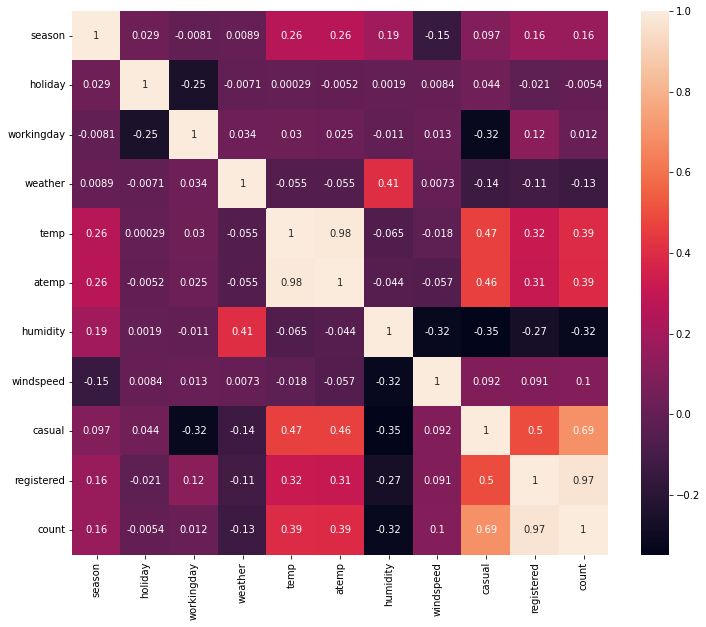

In [ ]:
# Pre-eliminatory correlation heatmap:
plt.subplots(figsize=(12,10))
sns.heatmap(df.corr(), annot=True)

First impression:

- disregard casual/registered as casual + registered = count

- workingday/holiday and casual are linked (suggesting the workday/weekend distinction is important for casual users; less so for registered users)

- multicollinearity between temp/atemp

- temperature is correlated with count, weather less so

- humidity is not correlated

- windspeed is somewhat correlated

- season is somewhat correlated

- distinct weather feautures seems to be more important than the weather variable itself

## Pre-Feature Engineering/ Data cleaning

---



### Create time-related features

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
def create_dt_features(df):
    df['year'] = pd.DatetimeIndex(df['datetime']).year
    df['month'] = pd.DatetimeIndex(df['datetime']).month
    df['day'] = pd.DatetimeIndex(df['datetime']).day
    df['hour'] = pd.DatetimeIndex(df['datetime']).hour
    df['Wday'] = pd.DatetimeIndex(df['datetime']).day_name()
create_dt_features(df)

In [ ]:
def time_of_day(df):
    df.loc[(df['hour']>18) & (df['hour']<=23), 'time_of_day'] = 'evening'
    df.loc[(df['hour']>=15) & (df['hour']<=18), 'time_of_day'] = 'afternoon'
    df.loc[(df['hour']>=10) & (df['hour']<=14), 'time_of_day'] = 'noon'
    df.loc[(df['hour']>=7) & (df['hour']<=9), 'time_of_day'] = 'morning'
    df.loc[(df['hour']<7), 'time_of_day'] = 'night'
time_of_day(df)

In [ ]:
# set datetime index and drop column
df.set_index(df['datetime'],inplace=True)
df.drop('datetime', axis=1,inplace=True)

### Check for missing values

In [ ]:
df.isnull().sum()

season         0
holiday        0
workingday     0
weather        0
temp           0
atemp          0
humidity       0
windspeed      0
casual         0
registered     0
count          0
year           0
month          0
day            0
hour           0
Wday           0
time_of_day    0
dtype: int64

### Check for outliers

In [ ]:
df['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Hour of the Day'),
 Text(0.5, 1.0, 'Box Plot on Hour of the Day')]

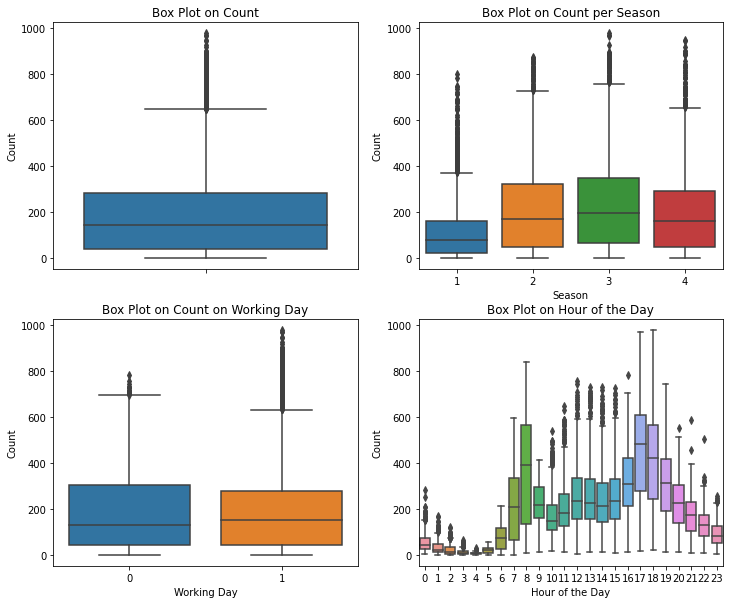

In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(12,10))
sns.boxplot(data=df,y='count', orient='v',ax=axes[0][0])
sns.boxplot(data=df,y='count', x='season',orient='v',ax=axes[0][1])
sns.boxplot(data=df,y='count', x='workingday',orient='v',ax=axes[1][0])
sns.boxplot(data=df,y='count', x='hour',orient='v',ax=axes[1][1])

axes[0][0].set(ylabel='Count',title='Box Plot on Count')
axes[0][1].set(ylabel='Count',xlabel='Season',title='Box Plot on Count per Season')
axes[1][0].set(ylabel='Count',xlabel='Working Day',title='Box Plot on Count on Working Day')
axes[1][1].set(ylabel='Count',xlabel='Hour of the Day',title='Box Plot on Hour of the Day')

In [ ]:
#removing outlier by values of z-score above 3
df_new = df[np.abs(df["count"]-df["count"].mean())<=(3*df["count"].std())]
print ("Shape Before: ",df.shape)
print ("Shape without Outliers: ",df_new.shape)

Shape Before:  (10886, 17)
Shape without Outliers:  (10739, 17)


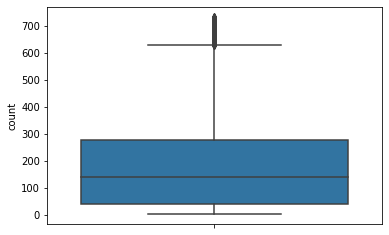

In [ ]:
sns.boxplot(data=df_new,y='count', orient='v')

## Exploratory Data Analysis

Guidelne questions:

- Examine whether the bicycle count shows any time-related patterns.
- How much of an impact does weather have on demand?
- How does the behavior of casual users differ from subscribers?
- Which other factors contribute most to the number of bicycles being checked out over the course of a given day?

### Explore time-related patterns

Text(0.5, 1.0, 'Bicycle count over time')

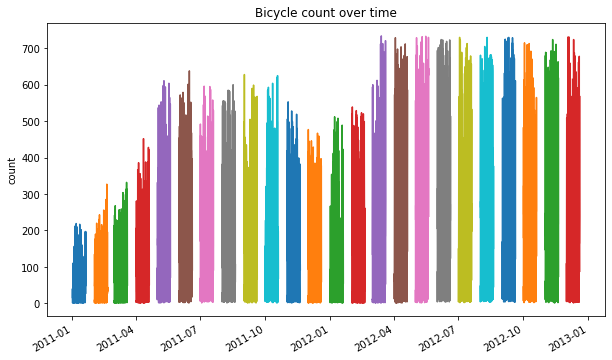

In [ ]:
df_new['count'].resample('M').plot(figsize=(10,6))
plt.ylabel('count')
plt.title('Bicycle count over time')

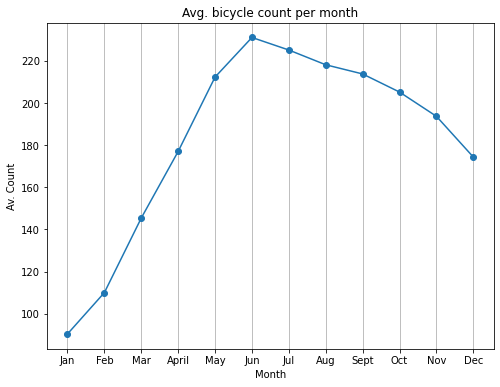

In [ ]:
x=df_new.groupby(['month'],sort = False)['count'].mean()
plt.figure(figsize=(8,6))
x=plt.plot(x,marker="o")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],['Jan','Feb','Mar','April','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec'])
plt.ylabel('Av. Count')
plt.xlabel('Month')
plt.title('Avg. bicycle count per month')
x=plt.gca()
x.xaxis.grid(True)

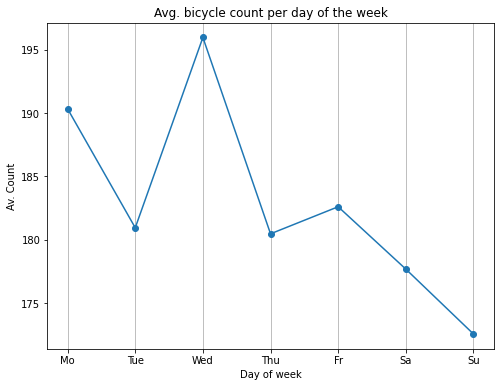

In [ ]:
x=df_new.groupby(['Wday'],sort = True)['count'].mean()
plt.figure(figsize=(8,6))
x=plt.plot(x,marker="o")
plt.xticks([0,1,2,3,4,5,6],['Mo','Tue','Wed','Thu','Fr','Sa','Su'])
plt.ylabel('Av. Count')
plt.xlabel('Day of week')
plt.title('Avg. bicycle count per day of the week')
x=plt.gca()
x.xaxis.grid(True)

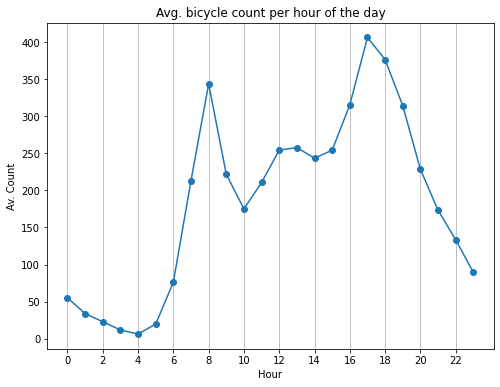

In [ ]:
x=df_new.groupby(['hour'],sort = True)['count'].mean()
plt.figure(figsize=(8,6))
x=plt.plot(x,marker="o")
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22])
x=plt.gca()
plt.xlabel('Hour')
plt.ylabel('Av. Count')
plt.title('Avg. bicycle count per hour of the day')
x.xaxis.grid(True)

trends in time related data

- there seems to be some kind of rush hour from 7 to 9 and from 17 to 19
- lower count on the weekend
- assumption: bikes mostly used for business?
- higher count on warmer months


### Weather importance

weather 
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy

- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

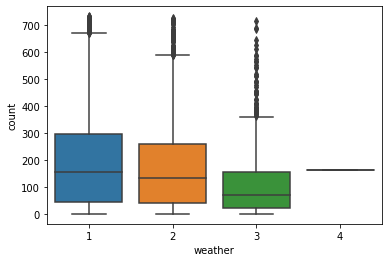

In [ ]:
sns.boxplot(data=df_new, y='count', x='weather')

Text(0.5, 1.0, 'Demand by weather')

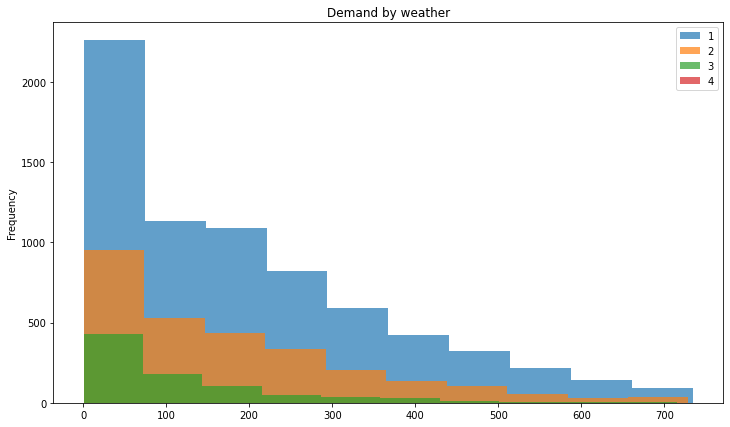

In [ ]:
plt.figure(figsize=(12,7))
df_new.groupby('weather')['count'].plot(kind='hist',alpha=0.7,legend='weather')
plt.title('Demand by weather')

In [ ]:
#sublots
hmd = df_new[['count', 'humidity']]
tmp = df_new[['count','temp']]
wind = df_new[['count','windspeed']]

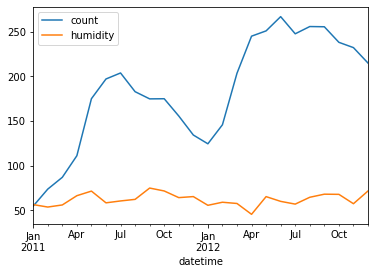

In [ ]:
hmd.resample('M').mean().plot()

Text(0.5, 1.0, 'Demand by humidity')

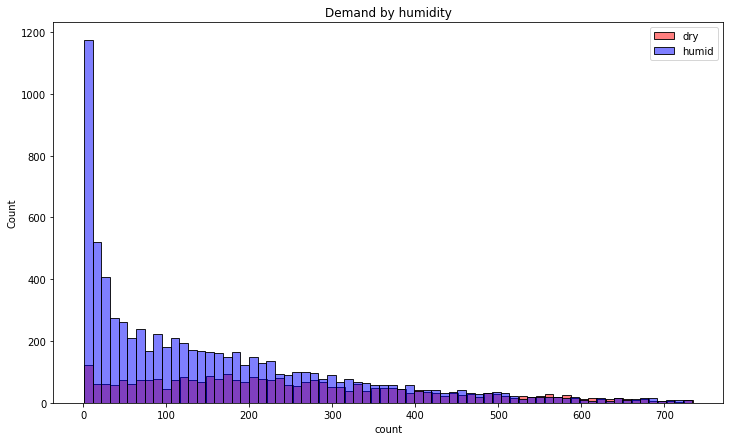

In [ ]:
dry = df_new.loc[df_new['humidity']<50.0]
humid = df_new.loc[df_new['humidity']>50.0]

plt.figure(figsize=(12,7))
sns.set_palette('muted')
sns.histplot(data=dry, x='count',alpha=0.5,bins=70,color='red')
sns.histplot(data=humid, x='count',alpha=0.5,bins=70,color='blue')
plt.legend(labels=["dry","humid"])
plt.title('Demand by humidity')

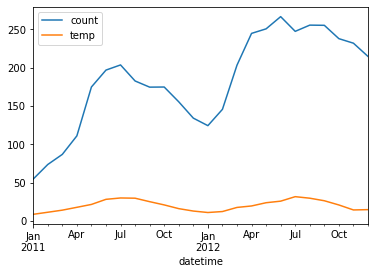

In [ ]:
tmp.resample('M').mean().plot()

Text(0.5, 1.0, 'Demand by temperature')

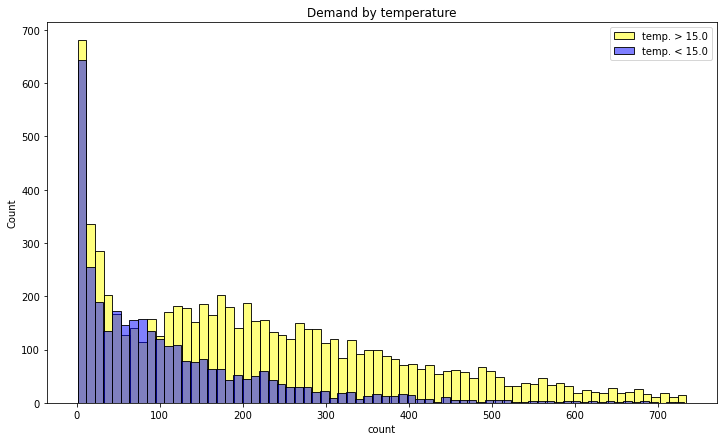

In [ ]:
warm_weather = df_new.loc[df_new['temp']>15.0]
cold_weather = df_new.loc[df_new['temp']<15.0]

plt.figure(figsize=(12,7))
sns.set_palette('muted')
sns.histplot(data=warm_weather, x='count',alpha=0.5,bins=70,color='yellow')
sns.histplot(data=cold_weather, x='count',alpha=0.5,bins=70,color='blue')
plt.legend(labels=["temp. > 15.0","temp. < 15.0"])
plt.title('Demand by temperature')

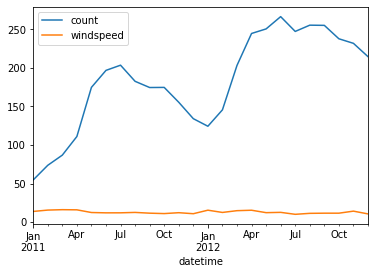

In [ ]:
wind.resample('M').mean().plot()

Text(0.5, 1.0, 'Demand by windspeed')

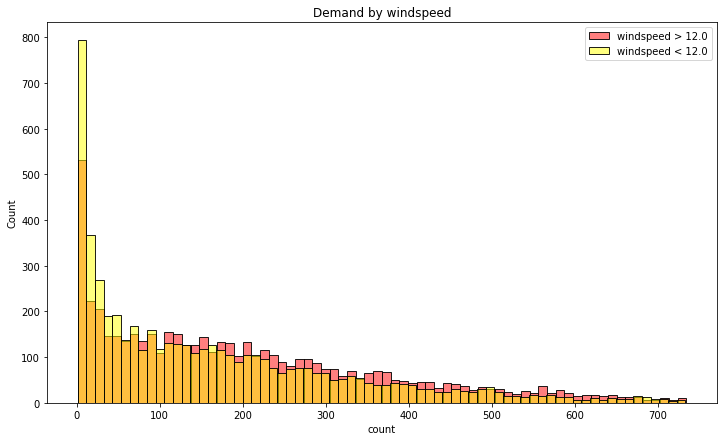

In [ ]:
windspeed = df_new.loc[df_new['windspeed']>12.0]
no_windspeed = df_new.loc[df_new['windspeed']<12.0]

plt.figure(figsize=(12,7))
sns.set_palette('muted')
sns.histplot(data=windspeed, x='count',alpha=0.5,bins=70,color='red')
sns.histplot(data=no_windspeed, x='count',alpha=0.5,bins=70,color='yellow')
plt.legend(labels=["windspeed > 12.0","windspeed < 12.0"])
plt.title('Demand by windspeed')

trends in weather related data
- better weather leads to higher counts
- on closer expection weather phenomenas influnece the count too 

### Members & Casual Riders

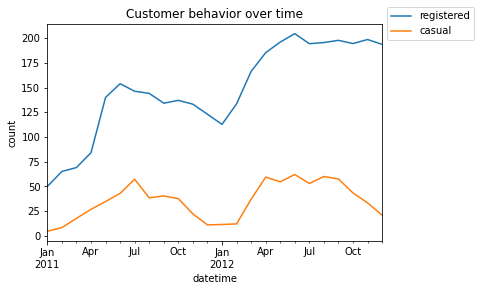

In [ ]:
plt.figure()
df_new['registered'].resample('M').mean().plot()
df_new['casual'].resample('M').mean().plot()
plt.title('Customer behavior over time')
plt.ylabel('count')
plt.legend(bbox_to_anchor=(1, 1.1), loc=2)

### Which other factors contribute most to the number of bicycles being checked out over the course of a given day?

#### holiday/working day

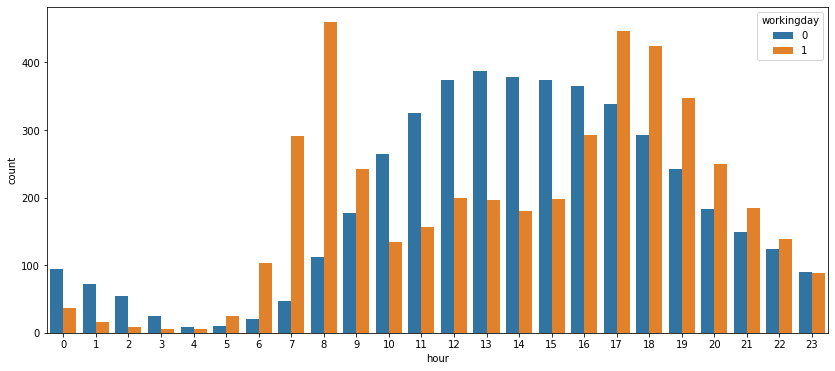

In [ ]:
hours = df_new.groupby(['hour', 'workingday']).mean()
hours.reset_index(inplace = True)

plt.figure(figsize=(14,6))
sns.barplot(x = 'hour', y = 'count', data = hours, hue = 'workingday')

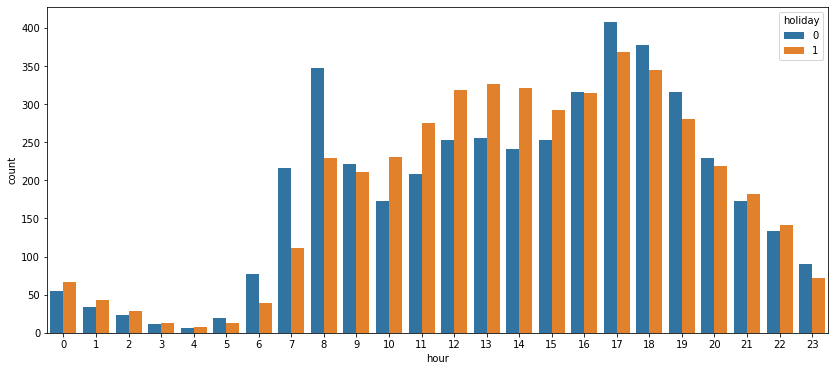

In [ ]:
hours = df_new.groupby(['hour', 'holiday']).mean()
hours.reset_index(inplace = True)

plt.figure(figsize=(14,6))
sns.barplot(x = 'hour', y = 'count', data = hours, hue = 'holiday')

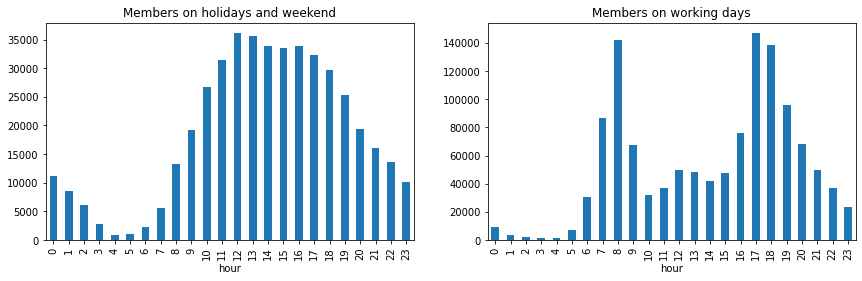

In [ ]:
# distribution of bike rentals on holidays vs working days for user types - rush hours vary significantly
fig2 = plt.figure()
ax = fig2.add_subplot(121)
df[df['workingday']==0].groupby(['hour']).sum()['registered'].plot.bar()
plt.title('Members on holidays and weekend')

ax = fig2.add_subplot(122)
df[df['workingday']==1].groupby(['hour']).sum()['registered'].plot.bar()
plt.title('Members on working days')
plt.subplots_adjust(right=2)

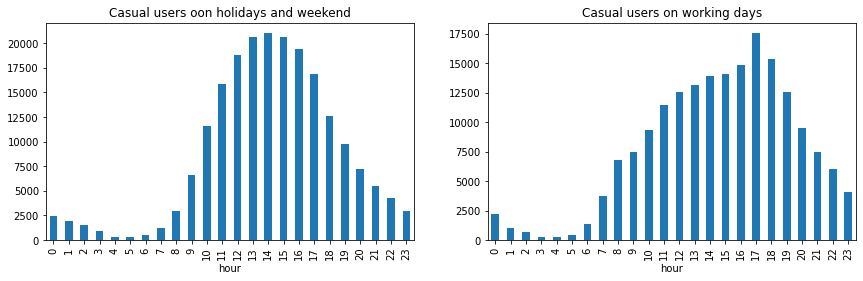

In [ ]:
# distribution of bike rentals on holidays vs working days - rush hours vary significantly
fig2 = plt.figure()
ax = fig2.add_subplot(121)
df[df['workingday']==0].groupby(['hour']).sum()['casual'].plot.bar()
plt.title('Casual users oon holidays and weekend')

ax = fig2.add_subplot(122)
df[df['workingday']==1].groupby(['hour']).sum()['casual'].plot.bar()
plt.title('Casual users on working days')
plt.subplots_adjust(right=2)
#plt.savefig('Rush_hour.png', bbox_inches = 'tight')

trends
- bike use on workingday during rush hour
- use on holiday over the course of the day
- casual users don't have an excessive use during the rush hour
- members follow the pattern rush hour for working day, noon - afternoon for holiday

#### season

Text(0.5, 1.0, 'Demand by season')

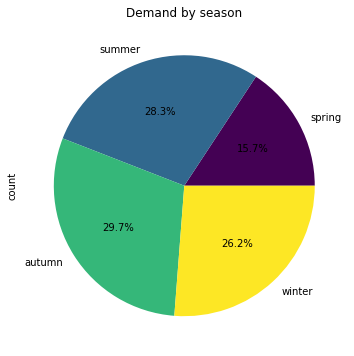

In [ ]:
plt.figure(figsize=(8,6))
labels =['spring','summer', 'autumn', 'winter']
df_new.groupby(df_new['season']).sum()['count'].plot.pie(legend = False, cmap='viridis',autopct="%.1f%%",labels=labels)
plt.title('Demand by season')

Text(0.5, 1.0, 'Average count per month')

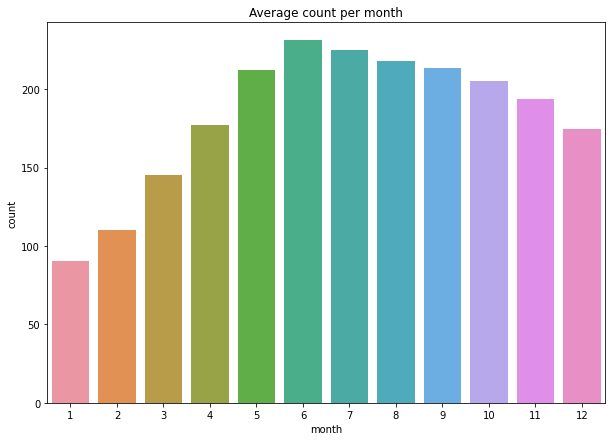

In [ ]:
plt.figure(figsize=(10,7))
monthAggregated = pd.DataFrame(df_new.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthSorted,x="month",y="count")
plt.title("Average count per month")

trends
- for season feature not such big differences between rentals, only spring sticks out as the lowest
- more details if looking at the months seperately -> january to march lowest, but november/december quite high in comparison

#### Combine features

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Season'),
 None]

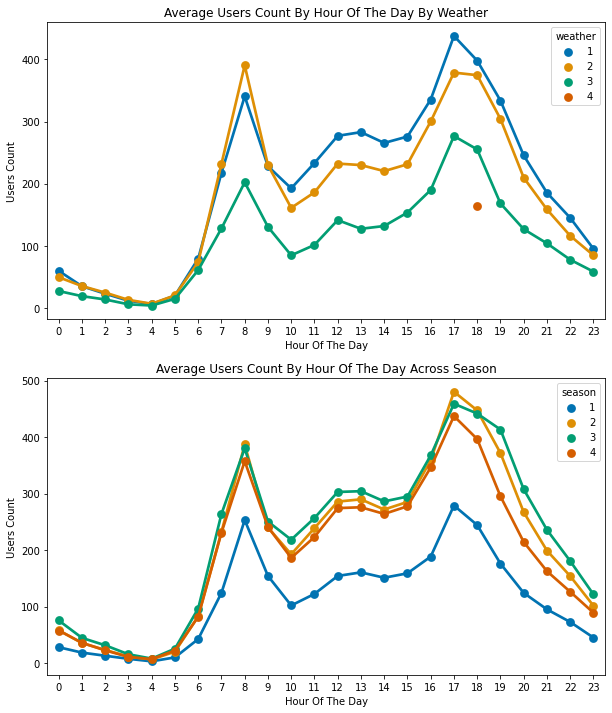

In [ ]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(10,12)
#sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

hourAggregated = pd.DataFrame(df_new.groupby(["hour","weather"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weather"],palette ='colorblind', data=hourAggregated, join=True,ax=ax1)
ax1.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day By Weather",label='big')

hourAggregated = pd.DataFrame(df_new.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"],palette ='colorblind', data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')


[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day By Workingday/Holiday'),
 None]

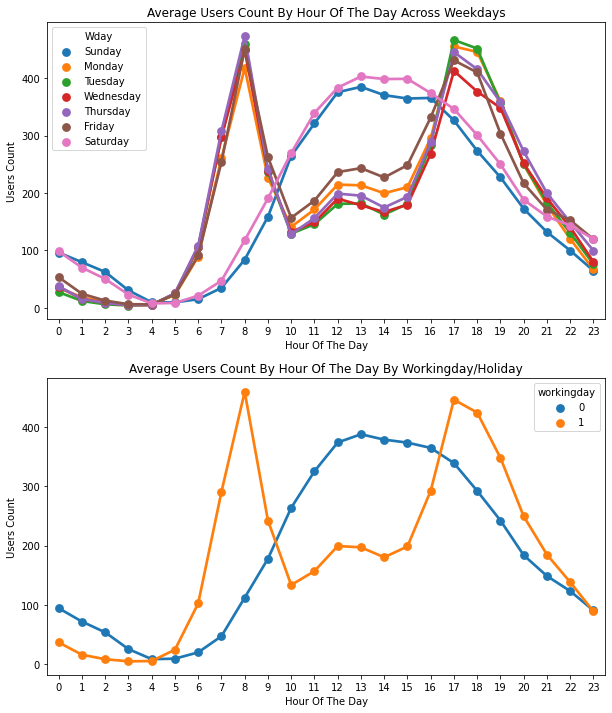

In [ ]:
fig,(ax3,ax4)= plt.subplots(nrows=2)
fig.set_size_inches(10,12)
#sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

hourAggregated = pd.DataFrame(df_new.groupby(["hour","Wday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["Wday"], hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

hourAggregated = pd.DataFrame(df_new.groupby(["hour","workingday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["workingday"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day By Workingday/Holiday",label='big')


trends
- the combination hour/workingday seems to have the biggest influnence on the count
- factor rush hour for workingdays with two peaks
- weekend/holidays counts follow a bell curve, peak on noon/afternoon
- same distribution we also see across the seasons and the weather feature, but with lower counts in spring and cold weather

### Explore correlation

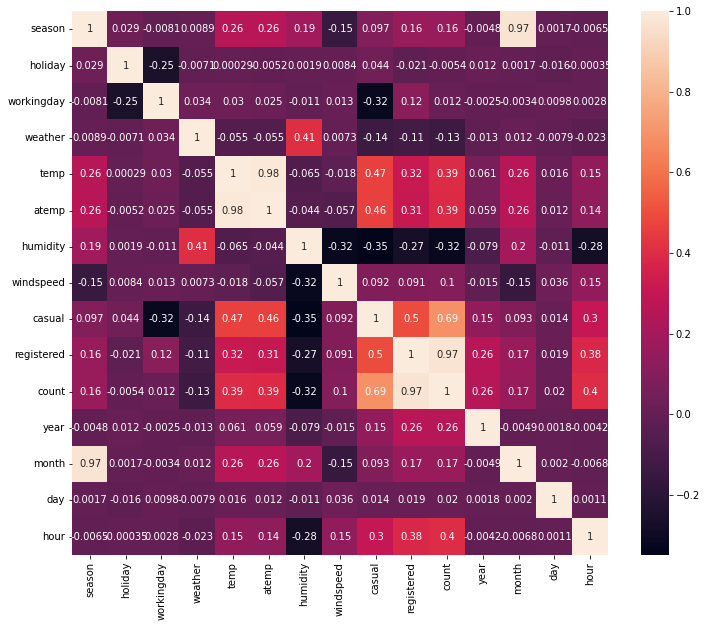

In [ ]:
plt.subplots(figsize=(12,10))
sns.heatmap(df.corr(), annot=True)

assumptions about multicollinearity
- choose season or month
- choose temp or atemp
- choose workingday over holiday
- don't take into account casual, registered, count as this is what we want to predict


other trends
- Weather and humidty are correlated
- Windspeed and humidity are negatively correlated
- Season has positive correlation with temp
- casual users are correlated with temp

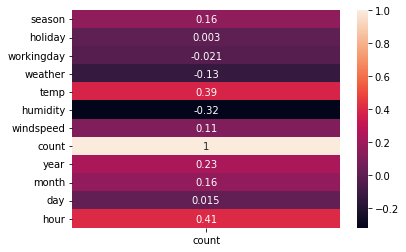

In [ ]:
sns.heatmap(df_new.drop(columns=['registered','atemp', 'casual']).corr()[['count']], annot=True)

 Which factors seem to have the strongest correlation with count?
- Temp and hour have strong positive correlation with count
- Season and month also show positive correlation with count
- Weather and humidity have small negative correlation with count

### Conclusions from data exploration

- Overall, there are some significant differences between casual and registered ridership patterns. This is interesting, but since we're only interested in the number of bikes rented at a given time, it's not relevant to further modelling.

Climate affects bike rental numbers in a variety of ways:
- Generally rentals peak in summer and are lowest in late winter/ early spring months.
- Higher temperatures are correlated with rentals.

Workingday affects bike rental numbers:
- Since holidays are a subcategory of non-workingdays, I want to focus on the workingday distinction -- holidays don't add any additional information.
- On working days, ridership patterns diverge. Registered users tend to use a bike at rush hour.
- On non-working days, ridership patterns are more similar, peaking around lunchtime.

Time of day is very important in predicting bike rentals. Rentals are lowest between midnight and 5 am, but then vary throughough the day, with big peaks around rush hour times (on workdays) or lunchtime (non-workdays).

## Train-Test Split


In [ ]:
y = df_new["count"]

X = df_new[['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed', 'month','hour', 'day', 'year']]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8591, 11), (2148, 11), (8591,), (2148,))

## Feature Selection

### Forward Selection with OLS

In [ ]:
from statsmodels.api import OLS, add_constant

m = OLS(y_train, add_constant(X_train))
m_result = m.fit()
print(m_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     474.0
Date:                Mon, 20 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:45:43   Log-Likelihood:                -54174.
No. Observations:                8591   AIC:                         1.084e+05
Df Residuals:                    8579   BIC:                         1.085e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.464e+05   5794.063    -25.273      0.0

In [ ]:
m_result.rsquared_adj

#Find the features with the lowest p-value , lower than 0.05

# Create a list of features
forward_features = []

# Original features
feature_list = X_train.columns

feature_list

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity',
       'windspeed', 'month', 'hour', 'day', 'year'],
      dtype='object')

In [ ]:
possible_models = pd.DataFrame(columns=['features', 'p', 'adj_r2'])
# Run a linear regression separately on each of the features

while len(feature_list) > 0:
    forward_selection = pd.DataFrame(columns=['features', 'p', 'adj_r2'])
    for feature in feature_list:
        m_feature = OLS(y_train, X_train[forward_features + [feature]])
        result = m_feature.fit()
        forward_selection = forward_selection.append({
                                    'feature': feature
                                  , 'features': forward_features + [feature]
                                  , 'p': result.pvalues.loc[feature]
                                  , 'adj_r2': result.rsquared_adj}
                                  , ignore_index=True)

    if forward_selection.sort_values('p').iloc[0].p < 0.05:
        print(forward_selection.sort_values('p').iloc[0].features)
        best_feature = forward_selection.sort_values('p').iloc[0].feature
        forward_features.append(best_feature)
        feature_list = feature_list.drop(best_feature)
        best_model = forward_selection[forward_selection['feature']==best_feature]
        possible_models = possible_models.append(best_model, ignore_index=True)

    else:
        break

['season']
['season', 'temp']
['season', 'temp', 'hour']
['season', 'temp', 'hour', 'humidity']
['season', 'temp', 'hour', 'humidity', 'year']
['season', 'temp', 'hour', 'humidity', 'year', 'month']
['season', 'temp', 'hour', 'humidity', 'year', 'month', 'workingday']


In [ ]:
forward_features

['season', 'temp', 'hour', 'humidity', 'year', 'month', 'workingday']

In [ ]:
feature_list

Index(['holiday', 'weather', 'windspeed', 'day'], dtype='object')

In [ ]:
forward_selection

,features,p,adj_r2,feature
0,"[season, temp, hour, humidity, year, month, wo...",0.986890,0.697024,holiday
1,"[season, temp, hour, humidity, year, month, wo...",0.237265,0.697073,weather
2,"[season, temp, hour, humidity, year, month, wo...",0.224350,0.697076,windspeed
3,"[season, temp, hour, humidity, year, month, wo...",0.512410,0.697039,day


In [ ]:
possible_models

,features,p,adj_r2,feature
0,[season],0.000000e+00,0.517107,season
1,"[season, temp]",0.000000e+00,0.614709,temp
2,"[season, temp, hour]",5.098125e-250,0.662590,hour
3,"[season, temp, hour, humidity]",2.530578e-180,0.693282,humidity
4,"[season, temp, hour, humidity, year]",5.538669e-15,0.695420,year
5,"[season, temp, hour, humidity, year, month]",2.665853e-10,0.696797,month
6,"[season, temp, hour, humidity, year, month, wo...",3.717307e-03,0.697059,workingday


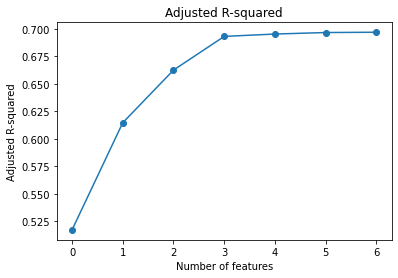

In [ ]:
possible_models['adj_r2'].plot(marker="o")
plt.title('Adjusted R-squared')
plt.xlabel('Number of features')
plt.ylabel('Adjusted R-squared')
plt.show()

assumption
- according to OLS we shoul exclude holiday, weather, windspeed and day from the model
- Recurisve Feature Elimination is also giving day holiday, windspeed and day
as features to exclude
- in contrast to OLS, RFE is givng weather as one of the most important features for the model and humidity as one of the worst

conclusion
- taking into account the EDA, we leave in weather and exclude holiday, windspeed, day, year and season from the model


In [ ]:
X_train = X_train.drop(columns=['year', 'windspeed','holiday', 'day','season'])
X_test = X_test.drop(columns=['year', 'windspeed','holiday', 'day','season'])
X_train.shape, X_test.shape

((8591, 6), (2148, 6))

In [ ]:
X_train.columns

Index(['workingday', 'weather', 'temp', 'humidity', 'month', 'hour'], dtype='object')

## Feature Engineering

---



In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer

In [ ]:
# one hot encode
# scale
one_hot_pipe = make_pipeline(
    (OneHotEncoder(sparse = False))
)

In [ ]:
# binning and scaling
bin_and_scale_pipe = make_pipeline(
    (StandardScaler()),
    (KBinsDiscretizer(n_bins=4, encode='onehot-dense', strategy='quantile')),
)

In [ ]:
# put all together with a column tranfsormer


feature_transform = make_column_transformer(
    (one_hot_pipe, ['hour', 'month', 'weather','workingday']),
    (bin_and_scale_pipe, ['temp','humidity'])
)

In [ ]:
# DO NOT FIT ON TEST DATA
feature_transform.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(sparse=False))]),
                                 ['hour', 'month', 'weather', 'workingday']),
                                ('pipeline-2',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('kbinsdiscretizer',
                                                  KBinsDiscretizer(encode='onehot-dense',
                                                                   n_bins=4))]),
                                 ['temp', 'humidity'])])

In [ ]:
X_train_transformed = feature_transform.transform(X_train)
X_train_transformed

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [ ]:
X_test_transformed = feature_transform.transform(X_test)
X_test_transformed

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_transformed,y_train)


LinearRegression()

In [ ]:
model.coef_, model.intercept_

(array([-9.23514227e+10, -9.23514228e+10, -9.23514228e+10, -9.23514228e+10,
        -9.23514228e+10, -9.23514228e+10, -9.23514227e+10, -9.23514226e+10,
        -9.23514224e+10, -9.23514226e+10, -9.23514226e+10, -9.23514226e+10,
        -9.23514226e+10, -9.23514226e+10, -9.23514226e+10, -9.23514226e+10,
        -9.23514225e+10, -9.23514224e+10, -9.23514224e+10, -9.23514225e+10,
        -9.23514226e+10, -9.23514226e+10, -9.23514227e+10, -9.23514227e+10,
         2.79489487e+15,  2.79489487e+15,  2.79489487e+15,  2.79489487e+15,
         2.79489487e+15,  2.79489487e+15,  2.79489487e+15,  2.79489487e+15,
         2.79489487e+15,  2.79489487e+15,  2.79489487e+15,  2.79489487e+15,
        -8.53823396e+14, -8.53823396e+14, -8.53823396e+14, -8.53823396e+14,
         4.72156586e+15,  4.72156586e+15,  1.18337213e+15,  1.18337213e+15,
         1.18337213e+15,  1.18337213e+15, -2.62675208e+15, -2.62675208e+15,
        -2.62675208e+15, -2.62675208e+15]), -5219165028987494.0)

#### Cross validation

In [ ]:
cross_val_score(model, X_train_transformed, y_train)

array([ 6.10586798e-01, -4.05649973e+23,  6.34493068e-01,  6.15993555e-01,
        6.21856741e-01])

#### Check for negtive values

In [ ]:
#calculate y pred
y_pred = model.predict(X_test_transformed)

In [ ]:

def negative_count(y):
     count = 0
     location = []
     for i in y:
          if i < 0:
               location.append(np.where(y_pred == i))
               count += 1
          
          else:
               continue
     
     return count, location

print(negative_count(y_pred))

(174, [(array([  13,  206,  747, 1377, 2091]),), (array([15]),), (array([  25, 1492]),), (array([  33,  103,  371,  566, 1383, 1417, 1779]),), (array([40]),), (array([45]),), (array([  76,  737, 1304, 1616, 1628, 1667, 1960]),), (array([ 78, 873]),), (array([ 79, 228, 407, 866]),), (array([  99,  608,  625,  663,  884, 1147, 1255, 1574]),), (array([102]),), (array([  33,  103,  371,  566, 1383, 1417, 1779]),), (array([ 116,  724, 1702]),), (array([ 124,  415, 1489]),), (array([128]),), (array([ 158, 1741]),), (array([ 173,  215,  723,  805, 1068, 1569]),), (array([  13,  206,  747, 1377, 2091]),), (array([ 173,  215,  723,  805, 1068, 1569]),), (array([217]),), (array([ 79, 228, 407, 866]),), (array([229]),), (array([230]),), (array([ 240,  307, 2048]),), (array([257]),), (array([278, 807]),), (array([ 240,  307, 2048]),), (array([ 343, 1685, 1735]),), (array([ 367, 1172]),), (array([  33,  103,  371,  566, 1383, 1417, 1779]),), (array([ 387, 2092]),), (array([ 388,  530,  679, 1000]),

In [ ]:
y_pred[y_pred < 0] = 0
print(negative_count(y_pred))

(0, [])


#### Model score

In [ ]:
round(model.score(X_train_transformed, y_train),2)

0.62

In [ ]:
round(model.score(X_train_transformed, y_train),2)

0.62

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_log_error
import numpy as np

rmse = np.sqrt(mean_squared_log_error(y_true=y_test, y_pred=y_pred))
r2 = r2_score(y_test,y_pred)
print(rmse)
print(r2)

1.0295611216818796
0.6544570210237894


# Optimize results


### Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
X_train.shape

(8591, 6)

In [ ]:
m_sl = LinearRegression()        
m_sl.fit(X_train, y_train)

LinearRegression()

In [ ]:
rfe = RFE(m_sl)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression())

In [ ]:
list(zip(X_train.columns,rfe.support_, rfe.ranking_))

[('workingday', True, 1),
 ('weather', False, 4),
 ('temp', True, 1),
 ('humidity', False, 3),
 ('month', False, 2),
 ('hour', True, 1)]

#### Recursive Feature Elimination with complete features

best features:
- workingday, weather, month, hour, year

worst features:
- day, windspeed, humidity, holiday

## Optimize the model

### Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_log_error
import numpy as np

In [ ]:
#defining the polynomial transformation 
poly = PolynomialFeatures(degree=2)
#fitting the columns to the transforming method
X_train_poly = poly.fit_transform(X_train_transformed)
#transforming the columns
X_test_poly = poly.transform(X_test_transformed) 

In [ ]:
m = LinearRegression() 

In [ ]:
#train the model 
m.fit(X_train_poly, y_train)

LinearRegression()

In [ ]:
round(m.score(X_train_poly, y_train),2)

0.84

In [ ]:
round(m.score(X_test_poly, y_test),2)

0.8

In [ ]:
cross_val_score(m, X_train_poly, y_train)

array([-4.10351898e+21,  8.28374074e-01,  8.13393842e-01,  8.14299884e-01,
       -2.81298886e+20])

In [ ]:
#calculating y pred
y_pred_poly = m.predict(X_test_poly)

In [ ]:
#checking the intercept
m.intercept_

144527711463818.1

In [ ]:
y_pred_poly[y_pred_poly < 0] = 0
print(negative_count(y_pred_poly))

(0, [])


In [ ]:
rmse = np.sqrt(mean_squared_log_error(y_true=y_test, y_pred=y_pred_poly))
r2 = r2_score(y_test,y_pred_poly)
print(rmse)
print(r2)

0.8969451128143431
0.8054700619862394


### Ridge

In [ ]:
# add ridge
m_ridge = Ridge(alpha=1.0)

m_ridge.fit(X_train_poly, y_train)
y_pred_ridge = m_ridge.predict(X_test_poly)


In [ ]:
round(m_ridge.score(X_train_poly, y_train),2)

0.842

In [ ]:
round(m_ridge.score(X_test_poly, y_test),2)

0.832

In [ ]:
cross_val_score(m_ridge, X_train_poly, y_train)

array([0.80660972, 0.82579686, 0.80600071, 0.81783884, 0.80012226])

In [ ]:
y_pred_ridge[y_pred_ridge < 0] = 0
print(negative_count(y_pred_ridge))

(0, [])


In [ ]:
rmse = np.sqrt(mean_squared_log_error(y_true=y_test, y_pred=y_pred_ridge))
r2 = r2_score(y_test,y_pred_ridge)
print(rmse)
print(r2)

0.8023133292647534
0.834034638054332


### Lasso

In [ ]:
from sklearn.linear_model import Lasso

m_lasso = Lasso(alpha=1.0)
m_lasso.fit(X_train_poly, y_train)
y_pred_lasso = m_lasso.predict(X_test_poly)

In [ ]:
round(m_lasso.score(X_train_poly, y_train),2)

0.73

In [ ]:
round(m_lasso.score(X_test_poly, y_test),2)

0.73

In [ ]:
cross_val_score(m_lasso, X_train_poly, y_train)

array([0.72916426, 0.74378155, 0.72537749, 0.73286307, 0.70923007])

In [ ]:
y_pred_lasso[y_pred_lasso < 0] = 0
print(negative_count(y_pred_lasso))

(0, [])


In [ ]:
rmse = np.sqrt(mean_squared_log_error(y_true=y_test, y_pred=y_pred_lasso))
r2 = r2_score(y_test,y_pred_lasso)
print(rmse)
print(r2)

0.9546031622032448
0.7290184069371666


# GridSearch for Hyperparameter Optimization

## Linear Regression

In [ ]:
pipe_lr = make_pipeline(PolynomialFeatures(degree=2),
    LinearRegression())

In [ ]:
params_lr = {'polynomialfeatures__degree': [1,2,4,6,8]} #degree 2 is the best

In [ ]:
gs_lr = GridSearchCV(pipe_lr, params_lr, 
                   return_train_score=True, 
                   scoring= "r2", 
                   cv=5).fit(X_train_transformed, y_train)

In [ ]:
gs_lr.best_params_

{'polynomialfeatures__degree': 2}

In [ ]:
res = pd.DataFrame(gs_lr.cv_results_)
c = ['param_polynomialfeatures__degree', 'mean_test_score', 'mean_train_score']
res.sort_values('mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomialfeatures__degree,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
1,0.058917,0.015069,0.012882,0.002826,2,{'polynomialfeatures__degree': 2},0.609374,0.635069,0.622222,0.012847,1,0.646636,0.621407,0.634021,0.012614
0,0.019406,0.007321,0.010293,0.001956,1,{'polynomialfeatures__degree': 1},0.462247,0.487069,0.474658,0.012411,2,0.489456,0.464756,0.477106,0.012350
2,1.123276,0.051608,0.045590,0.001280,4,{'polynomialfeatures__degree': 4},-1.067879,-24.868607,-12.968243,11.900364,3,0.836246,0.821830,0.829038,0.007208
3,94.152984,1.100927,1.093197,0.027154,8,{'polynomialfeatures__degree': 8},-13.424335,-1139.869868,-576.647101,563.222767,4,0.962632,0.965207,0.963920,0.001288


In [ ]:
pipe_lr.fit(X_train_transformed,y_train)

## Ridge

In [ ]:
estimator = Ridge()
estimator.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [ ]:
pipe_r = make_pipeline(PolynomialFeatures(),
    Ridge())

In [ ]:
params_r = {
    'polynomialfeatures__degree': [2,4,6,8],
    'ridge__alpha': [0.0001, 0.001, 0.05, 0.1, 1.0, 1.5]}

In [ ]:
gs_r = GridSearchCV(pipe_r, params_r, 
                   return_train_score=True, 
                   scoring="r2", 
                   cv=5).fit(X_train_transformed, y_train)

In [ ]:
gs_r.best_params_

In [ ]:
res = pd.DataFrame(gs_r.cv_results_)
c = ['param_polynomialfeatures__degree', 'mean_test_score', 'mean_train_score']
res.sort_values('mean_test_score', ascending=False)

In [ ]:
#pipe_r.fit(X_train_transformed,y_train)

# Compare score of all datasets

In [ ]:
#creating a ranking of the machine learning models, sorted by Training Score
results = pd.DataFrame({'Machine Learning Model': ['Linear Regression', 'Polynomial Features', 'Ridge', 'Lasso'],'Train Score': [0.63, 0.84, 0.84, 0.73], 'Test Score': [0.61, 0.80, 0.83, 0.73], 'r2': [1.0, 0.89, 0.80, 0.95], 'RMSE': [0.6, 0.80, 0.83, 0.72]})
result_df = results.sort_values(by='Test Score', ascending=False)
result_df = result_df.set_index('Machine Learning Model')
result_df.head(9)

,Train Score,Test Score,r2,RMSE
Machine Learning Model,,,,
Ridge,0.84,0.83,0.80,0.83
Polynomial Features,0.84,0.80,0.89,0.80
Lasso,0.73,0.73,0.95,0.72
Linear Regression,0.63,0.61,1.00,0.60
